In [1]:
import numpy as np
import matplotlib.pyplot as plt
import json
import random
import math
import statsmodels.api as sm
import matplotlib.pyplot as plt
from scipy import stats
from mpl_toolkits.mplot3d import Axes3D

# Extract cell activity and trial variables from simulation results

In [56]:
# Initialize arrays of interest variables 
# NOTE: each neuron's activity is a row; column index is trial number

N_PFC_NEURONS = 500
N_MD_NEURONS = 2
N_OUTPUT_NEURONS = 2
TRIAL_TIME = 200

s_trial = 0
t_trial = 4800
n_trials = t_trial - s_trial

rPFC_trials = np.zeros((n_trials, TRIAL_TIME, N_PFC_NEURONS))
rMD_trials = np.zeros((n_trials, TRIAL_TIME, N_MD_NEURONS))
task_input = np.zeros((2, n_trials))
v1v2_values = np.zeros((2, n_trials))
wPFC_output = np.zeros((n_trials, N_OUTPUT_NEURONS, N_PFC_NEURONS))

# Extract the data

data_dir = "/om2/group/halassa/PFCMD-ali-sabrina/020321_qvals/by_trial"

for i in range(s_trial, t_trial):
    with open(data_dir + "/" + str(i) + ".json") as json_file:
        data = json.load(json_file)
        idx = i - s_trial
                
        rPFC = np.array(data["network_rates"]["r_PFC"])
        rPFC_trials[idx,:,:] = rPFC
        
        rMD = np.array(data["network_rates"]["r_MD"])
        rMD_trials[idx,:,:] = rMD
        
        trial_task_input = np.array(data["trial_data"]["input"])
        task_input[:,idx] = trial_task_input[:2]
        v1v2_values[:,idx] = trial_task_input[2:]
        
        wPFC_output[idx,:,:] = np.array(data["network_weights"]["w_outputs"])


# Compute cue responsiveness across all 4 strategy/cue combinations

NOTE: We remove association level 0.5 form the analysis. 
Match strategy considers all trials in association level blocks of 0.7 and 0.9.
Non-match strategy considers all trials in association level blocks of 0.1 and 0.3.

## Util Functions

In [3]:
def logistic_regression(X, y):
    try:
        model_fit = sm.Logit(y,X).fit(maxiter=50)
        return model_fit.prsquared
    except np.linalg.LinAlgError:
        return 0
    except sm.tools.sm_exceptions.PerfectSeparationError:
        return 1 # Data is linearly separable
    
def linear_regression(x, y):    
    X = np.transpose([np.ones(len(x)), x])
    model_fit = sm.OLS(y, X).fit()
    return (model_fit.rsquared, model_fit.params[1], model_fit.params[0])

def sample_trials(alevel_idxs, n_samples):
    trial_per_alevel = 400
    trials_offset = 200 # Only consider the second half of the alevel
    
    trials_to_sample = []
    for n_bin in alevel_idxs:
        trial_s = n_bin * trial_per_alevel + trials_offset
        trial_t = (n_bin + 1) * 400
        trials_to_sample = trials_to_sample + list(range(trial_s, trial_t))
    return np.array(random.sample(trials_to_sample, n_samples))

## Step 1: Look for a linear relationship between trials and V1 value across match/non-match vs cue=up/cue=down trials.

In [55]:
SAVE_DIR = '/om2/group/halassa/PFCMD-ali-sabrina/032421_v1-permutations'

CUE_TIME = 100
TRIAL_SAMPLE_SIZE = 150

alevel_90_idxs = [0, 2, 4, 8, 10]
alevel_10_idxs = [1, 5, 11]
alevel_70_idxs = [3, 6]
alevel_30_idxs = [7]
alevel_50_idxs = [9]

V_r2 = np.zeros((N_PFC_NEURONS, 4))
V_coeff = np.zeros((N_PFC_NEURONS, 4))

for neuron_idx in range(N_PFC_NEURONS):
    
    # Randomly sample trials for analysis from the second half of each alevel
    # We ensure all alevels are equally represented
    
    alevel_90_trials = sample_trials(alevel_90_idxs, TRIAL_SAMPLE_SIZE)
    alevel_10_trials = sample_trials(alevel_10_idxs, TRIAL_SAMPLE_SIZE)
    alevel_70_trials = sample_trials(alevel_70_idxs, TRIAL_SAMPLE_SIZE)
    alevel_30_trials = sample_trials(alevel_30_idxs, TRIAL_SAMPLE_SIZE)

    match_trials = np.concatenate((alevel_90_trials, alevel_70_trials))
    nonmatch_trials = np.concatenate((alevel_10_trials, alevel_30_trials))
    trials = np.concatenate((match_trials, nonmatch_trials))
    
    # Get cue 1 value and neuron activity for each trial
    # Only consider the activity over the second half of the cue period
    
    cuetime_s = math.floor(CUE_TIME - (CUE_TIME / 2))
    cuetime_t = CUE_TIME
        
    cue = task_input[0, trials]    
    trials_match_cue1 = match_trials[np.where(cue[0:2*TRIAL_SAMPLE_SIZE])]
    trials_match_cue2 = match_trials[np.where(1-cue[0:2*TRIAL_SAMPLE_SIZE])]
    trials_nonmatch_cue1 = nonmatch_trials[np.where(cue[2*TRIAL_SAMPLE_SIZE:])]
    trials_nonmatch_cue2 = nonmatch_trials[np.where(1-cue[2*TRIAL_SAMPLE_SIZE:])]
        
    v1_match_cue1 = v1v2_values[0,trials_match_cue1]
    v1_match_cue2 = v1v2_values[0,trials_match_cue2]
    v1_nonmatch_cue1 = v1v2_values[0,trials_nonmatch_cue1]
    v1_nonmatch_cue2 = v1v2_values[0,trials_nonmatch_cue2]
    
    fr_match_cue1 = np.mean(rPFC_trials[trials_match_cue1, cuetime_s:cuetime_t, neuron_idx],1)
    fr_match_cue2 = np.mean(rPFC_trials[trials_match_cue2, cuetime_s:cuetime_t, neuron_idx],1)
    fr_nonmatch_cue1 = np.mean(rPFC_trials[trials_nonmatch_cue1, cuetime_s:cuetime_t, neuron_idx],1)
    fr_nonmatch_cue2 = np.mean(rPFC_trials[trials_nonmatch_cue2, cuetime_s:cuetime_t, neuron_idx],1)

    (r2_match_cue1, coeff_match_cue1, const_match_cue1) = linear_regression(fr_match_cue1, v1_match_cue1)
    (r2_match_cue2, coeff_match_cue2, const_match_cue2) = linear_regression(fr_match_cue2, v1_match_cue2)
    (r2_nonmatch_cue1, coeff_nonmatch_cue1, const_nonmatch_cue1) = linear_regression(fr_nonmatch_cue1, v1_nonmatch_cue1)
    (r2_nonmatch_cue2, coeff_nonmatch_cue2, const_nonmatch_cue2) = linear_regression(fr_nonmatch_cue2, v1_nonmatch_cue2)
    V_r2[neuron_idx,:] = [r2_match_cue1, r2_match_cue2, r2_nonmatch_cue1, r2_nonmatch_cue2]
    V_coeff[neuron_idx,:] = [coeff_match_cue1, coeff_match_cue2, coeff_nonmatch_cue1, coeff_nonmatch_cue2]

    
    plt.figure(figsize=(20,10))

    w = 0.3
    x = np.arange(4)
    ax1 = plt.subplot(2,4,1)
    plt.xticks(x, ["match/cue1", "match/cue2", "nonmatch/cue1", "nonmatch/cue2"])
    ax1.bar(x-w/2, V_r2[neuron_idx,:], width=w, color="red")
    plt.ylabel("R-squared")
    plt.ylim([0,1])
    ax2 = ax1.twinx()
    ax2.bar(x+w/2, abs(V_coeff[neuron_idx,:]), width=w)
    plt.ylabel("abs(Coeffs)")
    plt.title(f"Neuron idx = {neuron_idx}")

    ax2 = plt.subplot(2,4,5)
    ax2.scatter(fr_match_cue1, v1_match_cue1, marker=".")
    ax2.plot(x, V_coeff[neuron_idx,0]*x + const_match_cue1)
    ax2.set_xlim((0,1))
    ax2.set_ylim((0,1))
    ax2.set_title("match/cue1")
    ax2.set_xlabel("neuron firing rate")
    ax2.set_ylabel("V1 value")
    
    ax3 = plt.subplot(2,4,6)
    ax3.scatter(fr_match_cue2, v1_match_cue2, marker=".")
    ax3.plot(x, V_coeff[neuron_idx,1]*x + const_match_cue2)
    ax3.set_xlim((0,1))
    ax3.set_ylim((0,1))
    ax3.set_title("match/cue2")

    ax4 = plt.subplot(2,4,7)
    ax4.scatter(fr_nonmatch_cue1, v1_nonmatch_cue1, marker=".")
    ax4.plot(x, V_coeff[neuron_idx,2]*x + const_nonmatch_cue1)
    ax4.set_xlim((0,1))
    ax4.set_ylim((0,1))
    ax4.set_title("non-match/cue1")

    ax5 = plt.subplot(2,4,8)
    ax5.scatter(fr_nonmatch_cue2, v1_nonmatch_cue2, marker=".")
    ax5.plot(x, V_coeff[neuron_idx,3]*x + const_nonmatch_cue2)
    ax5.set_xlim((0,1))
    ax5.set_ylim((0,1))
    ax5.set_title("non-match/cue2")
    
    plt.savefig(f"{SAVE_DIR}/nidx={neuron_idx}.jpg", transparent=False)
    plt.close()



## Categorize by MD winner (/MD circuit) 
I noticed that the regression analysis was not matching what I saw by eye when sorting trials by association levels. Instead here I sort by the MD winning neuron (or the PFC circuit regime in action based on MD).
Nueron 1 is a perfect example of the wrong regression results when sorting on association levels.

In [73]:
SAVE_DIR = '/om2/group/halassa/PFCMD-ali-sabrina/032521_v1-permutations-MD'

CUE_TIME = 100
TRIAL_SAMPLE_SIZE = 150

cuetime_s = math.floor(CUE_TIME - (CUE_TIME / 2))
cuetime_t = CUE_TIME

alevel_90_idxs = [0, 2, 4, 8, 10]
alevel_10_idxs = [1, 5, 11]
alevel_70_idxs = [3, 6]
alevel_30_idxs = [7]
alevel_50_idxs = [9]

V_r2 = np.zeros((N_PFC_NEURONS, 4))
V_coeff = np.zeros((N_PFC_NEURONS, 4))

for neuron_idx in range(1,N_PFC_NEURONS):
    
    # Randomly sample trials for analysis from the second half of each alevel
    # We ensure all alevels are equally represented
    
    alevel_90_trials = sample_trials(alevel_90_idxs, TRIAL_SAMPLE_SIZE)
    alevel_10_trials = sample_trials(alevel_10_idxs, TRIAL_SAMPLE_SIZE)
    alevel_70_trials = sample_trials(alevel_70_idxs, TRIAL_SAMPLE_SIZE)
    alevel_30_trials = sample_trials(alevel_30_idxs, TRIAL_SAMPLE_SIZE)
    trials = np.concatenate((alevel_90_trials, alevel_10_trials, alevel_70_trials, alevel_30_trials))

    # NOTE: This assignment of which MD is match and non-match is only based on this example dataset
    MD_nonmatch = np.rint(np.mean(rMD_trials[trials, cuetime_s:cuetime_t, 1], 1)).astype(bool)
    MD_match = np.invert(MD_nonmatch)

    # Get cue 1 value and neuron activity for each trial
    # Only consider the activity over the second half of the cue period
        
    cue = task_input[0, trials].astype(bool)
    trials_match_cue1 = trials[cue * MD_match]
    trials_match_cue2 = trials[np.invert(cue) * MD_match]
    trials_nonmatch_cue1 = trials[cue * MD_nonmatch]
    trials_nonmatch_cue2 = trials[np.invert(cue) * MD_nonmatch]
            
    v1_match_cue1 = v1v2_values[0,trials_match_cue1]
    v1_match_cue2 = v1v2_values[0,trials_match_cue2]
    v1_nonmatch_cue1 = v1v2_values[0,trials_nonmatch_cue1]
    v1_nonmatch_cue2 = v1v2_values[0,trials_nonmatch_cue2]
        
    fr_match_cue1 = np.mean(rPFC_trials[trials_match_cue1, cuetime_s:cuetime_t, neuron_idx],1)
    fr_match_cue2 = np.mean(rPFC_trials[trials_match_cue2, cuetime_s:cuetime_t, neuron_idx],1)
    fr_nonmatch_cue1 = np.mean(rPFC_trials[trials_nonmatch_cue1, cuetime_s:cuetime_t, neuron_idx],1)
    fr_nonmatch_cue2 = np.mean(rPFC_trials[trials_nonmatch_cue2, cuetime_s:cuetime_t, neuron_idx],1)

    (r2_match_cue1, coeff_match_cue1, const_match_cue1) = linear_regression(fr_match_cue1, v1_match_cue1)
    (r2_match_cue2, coeff_match_cue2, const_match_cue2) = linear_regression(fr_match_cue2, v1_match_cue2)
    (r2_nonmatch_cue1, coeff_nonmatch_cue1, const_nonmatch_cue1) = linear_regression(fr_nonmatch_cue1, v1_nonmatch_cue1)
    (r2_nonmatch_cue2, coeff_nonmatch_cue2, const_nonmatch_cue2) = linear_regression(fr_nonmatch_cue2, v1_nonmatch_cue2)
    V_r2[neuron_idx,:] = [r2_match_cue1, r2_match_cue2, r2_nonmatch_cue1, r2_nonmatch_cue2]
    V_coeff[neuron_idx,:] = [coeff_match_cue1, coeff_match_cue2, coeff_nonmatch_cue1, coeff_nonmatch_cue2]

    
    plt.figure(figsize=(20,10))

    w = 0.3
    x = np.arange(4)
    ax1 = plt.subplot(2,4,1)
    plt.xticks(x, ["match/cue1", "match/cue2", "nonmatch/cue1", "nonmatch/cue2"])
    ax1.bar(x-w/2, V_r2[neuron_idx,:], width=w, color="red")
    plt.ylabel("R-squared")
    plt.ylim([0,1])
    ax2 = ax1.twinx()
    ax2.bar(x+w/2, abs(V_coeff[neuron_idx,:]), width=w)
    plt.ylim([0,10])
    plt.ylabel("abs(Coeffs)")
    plt.title(f"Neuron idx = {neuron_idx}")

    ax2 = plt.subplot(2,4,5)
    ax2.scatter(fr_match_cue1, v1_match_cue1, marker=".")
    ax2.plot(x, V_coeff[neuron_idx,0]*x + const_match_cue1)
    ax2.set_xlim((0,1))
    ax2.set_ylim((0,1))
    ax2.set_title("match/cue1")
    ax2.set_xlabel("neuron firing rate")
    ax2.set_ylabel("V1 value")
    
    ax3 = plt.subplot(2,4,6)
    ax3.scatter(fr_match_cue2, v1_match_cue2, marker=".")
    ax3.plot(x, V_coeff[neuron_idx,1]*x + const_match_cue2)
    ax3.set_xlim((0,1))
    ax3.set_ylim((0,1))
    ax3.set_title("match/cue2")

    ax4 = plt.subplot(2,4,7)
    ax4.scatter(fr_nonmatch_cue1, v1_nonmatch_cue1, marker=".")
    ax4.plot(x, V_coeff[neuron_idx,2]*x + const_nonmatch_cue1)
    ax4.set_xlim((0,1))
    ax4.set_ylim((0,1))
    ax4.set_title("non-match/cue1")

    ax5 = plt.subplot(2,4,8)
    ax5.scatter(fr_nonmatch_cue2, v1_nonmatch_cue2, marker=".")
    ax5.plot(x, V_coeff[neuron_idx,3]*x + const_nonmatch_cue2)
    ax5.set_xlim((0,1))
    ax5.set_ylim((0,1))
    ax5.set_title("non-match/cue2")
    
    plt.savefig(f"{SAVE_DIR}/nidx={neuron_idx}.jpg", transparent=False)
    plt.close()

In [30]:
SAVE_DIR = '/om2/group/halassa/PFCMD-ali-sabrina/032421_v1-permutations'

CUE_TIME = 100
TRIAL_SAMPLE_SIZE = 150

alevel_90_idxs = [0, 2, 4, 8, 10]
alevel_10_idxs = [1, 5, 11]
alevel_70_idxs = [3, 6]
alevel_30_idxs = [7]
alevel_50_idxs = [9]

V = np.zeros((N_PFC_NEURONS, 4))

for neuron_idx in range(N_PFC_NEURONS):
    
    # Randomly sample trials for analysis from the second half of each alevel
    # We ensure all alevels are equally represented
    
    alevel_90_trials = sample_trials(alevel_90_idxs, TRIAL_SAMPLE_SIZE)
    alevel_10_trials = sample_trials(alevel_10_idxs, TRIAL_SAMPLE_SIZE)
    alevel_70_trials = sample_trials(alevel_70_idxs, TRIAL_SAMPLE_SIZE)
    alevel_30_trials = sample_trials(alevel_30_idxs, TRIAL_SAMPLE_SIZE)

    match_trials = np.concatenate((alevel_90_trials, alevel_70_trials))
    nonmatch_trials = np.concatenate((alevel_10_trials, alevel_30_trials))
    trials = np.concatenate((match_trials, nonmatch_trials))
    
    # Get cue 1 value and neuron activity for each trial
    # Only consider the activity over the second half of the cue period
    
    cuetime_s = math.floor(CUE_TIME - (CUE_TIME / 2))
    cuetime_t = CUE_TIME
        
    cue = task_input[0, trials]    
    trials_match_cue1 = match_trials[np.where(cue[0:2*TRIAL_SAMPLE_SIZE])]
    trials_match_cue2 = match_trials[np.where(1-cue[0:2*TRIAL_SAMPLE_SIZE])]
    trials_nonmatch_cue1 = nonmatch_trials[np.where(cue[2*TRIAL_SAMPLE_SIZE:])]
    trials_nonmatch_cue2 = nonmatch_trials[np.where(1-cue[2*TRIAL_SAMPLE_SIZE:])]
        
    v1_match_cue1 = v1v2_values[0,trials_match_cue1]
    v1_match_cue2 = v1v2_values[0,trials_match_cue2]
    v1_nonmatch_cue1 = v1v2_values[0,trials_nonmatch_cue1]
    v1_nonmatch_cue2 = v1v2_values[0,trials_nonmatch_cue2]
    
    fr_match_cue1 = np.mean(rPFC_trials[match_trials, cuetime_s:cuetime_t, neuron_idx],1)
    fr_match_cue2 = np.mean(rPFC_trials[match_trials, cuetime_s:cuetime_t, neuron_idx],1)
    fr_nonmatch_cue1 = np.mean(rPFC_trials[nonmatch_trials, cuetime_s:cuetime_t, neuron_idx],1)
    fr_nonmatch_cue2 = np.mean(rPFC_trials[nonmatch_trials, cuetime_s:cuetime_t, neuron_idx],1)

    r2_match_cue1_logr = logistic_regression(fr_match_cue1, task_input[0,match_trials])
    r2_match_cue1_linr = linear_regression(fr_match_cue2, task_input[0,match_trials])
    r2_nonmatch_cue1_logr = logistic_regression(fr_nonmatch_cue1, task_input[0,nonmatch_trials])
    r2_nonmatch_cue1_linr = linear_regression(fr_nonmatch_cue2, task_input[0,nonmatch_trials])
    V[neuron_idx,:] = [r2_match_cue1_logr,  r2_match_cue1_linr, r2_nonmatch_cue1_logr, r2_nonmatch_cue1_linr,]
    
#     plt.bar(["match/cue1", "match/cue2", "nonmatch/cue1", "nonmatch/cue2"], V[neuron_idx,:])
#     plt.ylabel("R-squared")
#     plt.title(f"Neuron idx = {neuron_idx}")
#     plt.ylim([0,1])
#     plt.savefig(f"{SAVE_DIR}/nidx={neuron_idx}.jpg", transparent=False)
#     plt.close()


Optimization terminated successfully.
         Current function value: 0.677357
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.392954
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.605702
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.392047
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.634384
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.454415
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.329160
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.412048
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.628146
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.692786
 

Optimization terminated successfully.
         Current function value: 0.687170
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689512
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.381907
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.675446
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.561339
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.451971
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.591035
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.601382
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.388460
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.408768
 

Optimization terminated successfully.
         Current function value: 0.627127
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.692005
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.681754
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.680787
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.692720
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.692316
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.341965
         Iterations 18
Optimization terminated successfully.
         Current function value: 0.348884
         Iterations 31
Optimization terminated successfully.
         Current function value: 0.661967
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.618630


/om2/user/ahummos/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


Optimization terminated successfully.
         Current function value: 0.510866
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.466897
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.575849
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.488040
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.391435
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.357315
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.381386
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.411220
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.674993
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.441327
  

/om2/user/ahummos/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "
/om2/user/ahummos/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


Optimization terminated successfully.
         Current function value: 0.674715
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.574452
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.638212
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.671189
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.615303
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.670313
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.519415
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.579136
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.668640
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.660069
  

         Iterations 5
Optimization terminated successfully.
         Current function value: 0.603716
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.665584
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.475522
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.685838
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.381046
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.680765
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.408095
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.660262
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686033
         Iterations 4
Optimization terminated successfully.
         Current funct

Optimization terminated successfully.
         Current function value: 0.676418
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.676404
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689828
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.639050
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.613261
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.396756
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.687468
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.581913
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.622597
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.597822
  

Optimization terminated successfully.
         Current function value: 0.383740
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.693144
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.658441
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.554773
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.693143
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.608794
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.644934
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.675456
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.638821
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.691603
  

Optimization terminated successfully.
         Current function value: 0.445863
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.652646
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691010
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.404033
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.434847
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.579100
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.631740
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.626930
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.418770
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.629883
  

Optimization terminated successfully.
         Current function value: 0.617788
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.692725
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.531336
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.686844
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.600097
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.605794
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.456707
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.481416
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.369832
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.657508
  

/om2/user/ahummos/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "
/om2/user/ahummos/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


Optimization terminated successfully.
         Current function value: 0.402779
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.680180
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.483149
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.638480
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.462201
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.677771
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.662681
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.574781
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.576220
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.613933
  

/om2/user/ahummos/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


Optimization terminated successfully.
         Current function value: 0.459645
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.678564
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.411728
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.518954
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.434908
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.425609
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.382907
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.551788
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.599135
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.499808
  

/om2/user/ahummos/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "
/om2/user/ahummos/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "
/om2/user/ahummos/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "
/om2/user/ahummos/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "



         Current function value: 0.699072
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.692725
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.679112
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683944
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.343504
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.346983
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.339642
         Iterations 16
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.348884
         Iterations 15
Optimization terminated successfully.
         Current function value: 0.676018
         Iterations 4
Optimization terminated successfully.
         Current

/om2/user/ahummos/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "
/om2/user/ahummos/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "
/om2/user/ahummos/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


Optimization terminated successfully.
         Current function value: 0.693129
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.395710
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.691698
         Iterations 3
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.681388
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.397404
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.693147
         Iterations 1
Optimization terminated successfully.
         Current function value: 0.682949
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.468179
         Iterations 7
         Current function value: 0.551050
         Iterations: 50
         Current function value: 0.358126
         Itera

/om2/user/ahummos/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "
/om2/user/ahummos/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "
/om2/user/ahummos/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "
/om2/user/ahummos/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "
/om2/user/ahummos/anaconda/lib/python3.8/site-pa

         Current function value: inf
         Iterations: 50
         Current function value: 0.346574
         Iterations: 50
         Current function value: 0.348884
         Iterations: 50
         Current function value: 0.337332
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.693105
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.659138
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.482812
         Iterations 6
         Current function value: 0.690837
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.693147
         Iterations 1
Optimization terminated successfully.
         Current function value: 0.629497
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.678392
         Iterations 9
Optimization terminated successfully.
         Current function

/om2/user/ahummos/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "
/om2/user/ahummos/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "
/om2/user/ahummos/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "



         Current function value: 0.597807
         Iterations 5
         Current function value: 0.455170
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.693147
         Iterations 1
Optimization terminated successfully.
         Current function value: 0.691891
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.486189
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.599801
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.646343
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.408957
         Iterations 39
Optimization terminated successfully.
         Current function value: 0.690837
         Iterations 29
Optimization terminated successfully.
         Current function value: 0.363495
         Iterations 10
Optimization terminated successfully.
         Cur

/om2/user/ahummos/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "
/om2/user/ahummos/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "
/om2/user/ahummos/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


         Current function value: 0.351195
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.660800
         Iterations 17
Optimization terminated successfully.
         Current function value: 0.415868
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.689140
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684910
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.406140
         Iterations 9
         Current function value: 0.323469
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.507947
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.692934
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.651311
         Ite

/om2/user/ahummos/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "
/om2/user/ahummos/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "
/om2/user/ahummos/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "
/om2/user/ahummos/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.633180
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.526993
         Iterations 6
         Current function value: 0.686076
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.693147
         Iterations 1
Optimization terminated successfully.
         Current function value: 0.688869
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.690245
         Iterations 6
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.323469
         Iterations 19
         Current function value: 0.355816
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.656179
         Iterations 34
Optimization terminated succes

/om2/user/ahummos/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "
/om2/user/ahummos/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


Optimization terminated successfully.
         Current function value: 0.602375
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.360283
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.397016
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.680613
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.316920
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.379197
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.639511
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.492882
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.693147
         Iterations 1
         Current function value: 0.560776
         Iterations: 50
Optimizatio

/om2/user/ahummos/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "
/om2/user/ahummos/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "
/om2/user/ahummos/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "
/om2/user/ahummos/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


In [31]:
V[:, 0]

array([ 1.13070209e-02,  1.25455729e-01,  8.37201713e-02,  5.18934386e-01,
        9.30500299e-02,  5.27913573e-01,  7.90854261e-02,  5.33690450e-03,
        1.79340405e-01,  4.37331207e-01,  4.51022315e-01,  4.19444431e-03,
        1.09102904e-03,  1.23101903e-02,  3.49038272e-02,  1.49567209e-01,
        3.81041713e-02,  1.40864289e-01,  2.74985991e-02,  3.90105070e-02,
        3.96694105e-02,  1.12227104e-01,  4.68985268e-02, -1.13371186e-04,
        3.93044735e-01,  3.91659676e-02,  8.57809659e-03,  7.77185528e-04,
        1.34460636e-01,  4.48688769e-03,  1.66961957e-02,  7.99686576e-02,
        1.66034037e-04,  7.70729152e-02,  1.61874936e-01,  5.57294185e-02,
        1.02576465e-03,  1.88409836e-01,  1.82152108e-02,  1.08818883e-01,
        1.39481515e-02,  1.65830384e-01, -1.80935328e-04,  2.29981772e-02,
        3.47860554e-01,  1.32138276e-01,  4.05383224e-01,  1.45057312e-01,
        2.17667715e-01,  4.48279755e-01,  1.05548925e-01,  9.72901429e-03,
        2.62248920e-01,  

Trying both Log reg and lin reg. I'm wary of log reg, because my understanding is you use it when the value to predict is binary, rather than the regressors being binary.

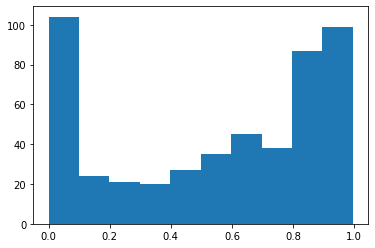

In [42]:
#Plotting the lin reg R2 for cue1 responsive cells in match context
_=plt.hist(V[:,1])

In [49]:
# get the indices of the most cue1 responsive neurons
sorted_idx = np.argsort(V[:,1])
highest_100_in_match =sorted_idx[:100]
highest_100_in_match.sort()
highest_100_in_match

array([  0,   6,  11,  12,  23,  27,  29,  30,  32,  38,  42,  55,  68,
        75,  96, 103, 110, 121, 124, 138, 141, 142, 144, 147, 151, 158,
       166, 174, 195, 196, 201, 202, 227, 232, 234, 235, 245, 257, 271,
       275, 293, 294, 299, 300, 303, 311, 322, 327, 328, 332, 351, 361,
       365, 367, 375, 381, 392, 400, 402, 403, 404, 405, 410, 411, 413,
       415, 416, 418, 421, 423, 424, 429, 433, 436, 440, 441, 450, 451,
       452, 457, 460, 461, 464, 466, 468, 470, 472, 474, 476, 478, 479,
       481, 483, 485, 488, 489, 490, 491, 495, 496])

In [50]:
# get the indices of the most cue1 responsive neurons
sorted_idx = np.argsort(V[:,3])
highest_100_in_non_match =sorted_idx[:100]
highest_100_in_non_match.sort()
highest_100_in_non_match

array([ 11,  22,  55,  66,  75,  76,  78,  87,  88,  90, 104, 130, 136,
       151, 153, 157, 160, 169, 176, 194, 196, 200, 204, 211, 220, 221,
       232, 233, 237, 240, 243, 244, 252, 268, 269, 273, 277, 278, 279,
       282, 284, 289, 298, 306, 348, 351, 352, 355, 357, 362, 365, 370,
       378, 380, 384, 386, 400, 401, 402, 403, 409, 410, 411, 412, 413,
       414, 417, 418, 422, 423, 424, 425, 426, 431, 435, 437, 438, 439,
       440, 442, 446, 447, 448, 458, 460, 461, 463, 467, 468, 471, 473,
       475, 477, 481, 483, 484, 486, 489, 490, 497])

In [51]:
np.intersect1d( highest_100_in_match, highest_100_in_non_match)

array([ 11,  55,  75, 151, 196, 232, 351, 365, 400, 402, 403, 410, 411,
       413, 418, 423, 424, 440, 460, 461, 468, 481, 483, 489, 490])

## Find neurons that are have a relationship in exactly one of the permutations

In [16]:
diffs = np.zeros(N_PFC_NEURONS)
maxs = np.zeros(N_PFC_NEURONS)

max_match_cue1 = []
max_match_cue2 = []
max_nonmatch_cue1 = []
max_nonmatch_cue2 = []

max2_match_cue1 = []
max2_match_cue2 = []
max2_nonmatch_cue1 = []
max2_nonmatch_cue2 = []

neurons_match_cue1 = []
neurons_match_cue2 = []
neurons_nonmatch_cue1 = []
neurons_nonmatch_cue2 = []
t_max = 0.6
t_diff = 0.4

for neuron_idx in range(N_PFC_NEURONS):
    r2_vals = V[neuron_idx,:]
    max_r2 = max(r2_vals)
    
    max_indicies = np.where(r2_vals == max_r2)[0]
    if len(max_indicies) == 2:
        maxs[neuron_idx] = max_r2
        diffs[neuron_idx] = 0
        continue
    
    max_idx = max_indicies[0]
    r2_vals_tmp = r2_vals.copy()
    r2_vals_tmp[max_idx] = 0
    max2_r2 = max(r2_vals_tmp)
    diffs[neuron_idx] = max_r2 - max2_r2
    maxs[neuron_idx] = max_r2
    
    if not (maxs[neuron_idx] >= t_max and diffs[neuron_idx] >= t_diff):
        continue

    if max_idx == 0:
        neurons_match_cue1.append(neuron_idx)
        max_match_cue1.append(max_r2)
        max2_match_cue1.append(max2_r2)
    elif max_idx == 1:
        neurons_match_cue2.append(neuron_idx)
        max_match_cue2.append(max_r2)
        max2_match_cue2.append(max2_r2)
    elif max_idx == 2:
        neurons_nonmatch_cue1.append(neuron_idx)
        max_nonmatch_cue1.append(max_r2)
        max2_nonmatch_cue1.append(max2_r2)
    elif max_idx == 3:
        neurons_nonmatch_cue2.append(neuron_idx)
        max_nonmatch_cue2.append(max_r2)
        max2_nonmatch_cue2.append(max2_r2)
        
example_neuron = neurons_match_cue1[3]
r2_vals = V[example_neuron,:]
plt.bar(["match_cue1", "match_cue2", "nonmatch_cue1", "nonmatch_cue2"], r2_vals)
plt.title("Example nonmatch_cue1 neuron")
plt.ylabel("R^2 value")
plt.show()

plt.hist(maxs, bins=40)
plt.xlabel("Max R^2")
plt.ylabel("Num neurons")
plt.title("Histogram of max R^2 value per neuron")
plt.show()

plt.hist(diffs, bins=40)
plt.xlabel("max R^2 - second max R^2")
plt.ylabel("Num neurons")
plt.title("Histogram of difference of max and second to max R^2 value per neuron")
plt.show()
    
D = {}
D["match_cue1"] = (max_match_cue1, max2_match_cue1)
D["match_cue2"] = (max_match_cue2, max2_match_cue2)
D["nonmatch_cue1"] = (max_nonmatch_cue1, max2_nonmatch_cue1)
D["nonmatch_cue2"] = (max_nonmatch_cue2, max2_nonmatch_cue2)

# Plot bar plot
means1 = []
means2 = []
std_errs1 = []
std_errs2 = []

d1s = []
d2s = []
for key in D:
    d1 = D[key][0]
    d2 = D[key][1]
    means1.append(np.mean(d1))
    means2.append(np.mean(d2))
    std_errs1.append(np.std(d1) / math.sqrt(len(d1)))
    std_errs2.append(np.std(d2) / math.sqrt(len(d2)))
    d1s.append(d1)
    d2s.append(d2)

w = 0.3
plt.bar(range(len(means1)), means1, width=w, label="max")
plt.errorbar(D.keys(), means1, std_errs1, color="k", capsize=2, zorder=20)
plt.bar(np.arange(len(means2))+w, means2, width=w, label="second max")
plt.errorbar(np.arange(len(std_errs2))+w, means2, std_errs2, color="k", capsize=2, zorder=20)
for i in range(len(d1s)):
    plt.scatter(np.ones(len(d1s[i]))*i, d1s[i], color="grey", marker="x", s=10, zorder=10)
    plt.scatter(np.ones(len(d2s[i]))*i+w, d2s[i], color="grey", marker="x", s=10, zorder=10)
plt.legend()
plt.ylabel("R^2 Value")
plt.title(f"Summary of found selective neurons (t_max={t_max}, t_diff={t_diff})")
plt.show()



IndexError: list index out of range

(array([ 99.,  27.,  25.,  21.,  26.,  24.,  30.,  53.,  66., 129.]),
 array([0.        , 0.09976691, 0.19953383, 0.29930074, 0.39906765,
        0.49883456, 0.59860148, 0.69836839, 0.7981353 , 0.89790222,
        0.99766913]),
 <a list of 10 Patch objects>)

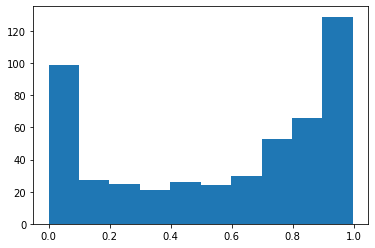

In [22]:
plt.hist(V[:,1])

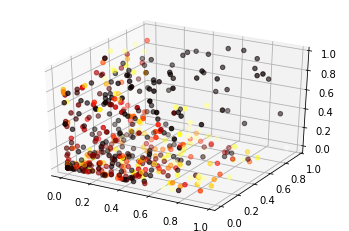

In [131]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(V[:,0], V[:,1],V[:,2], c=V[:,3])
plt.show()

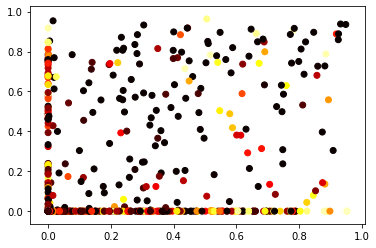